In [1]:
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Admission_Predict.csv')
df

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


In [3]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [4]:
x = df.drop(columns = ['Serial No.', 'Chance of Admit '])
x

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0
...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1
496,337,117,5,5.0,5.0,9.87,1
497,330,120,5,4.5,5.0,9.56,1
498,312,103,4,4.0,5.0,8.43,0


In [5]:
y = df['Chance of Admit ']
y

0      0.92
1      0.76
2      0.72
3      0.80
4      0.65
       ... 
495    0.87
496    0.96
497    0.93
498    0.73
499    0.84
Name: Chance of Admit , Length: 500, dtype: float64

In [12]:
from sklearn.metrics import mean_squared_error

def objective(trail, data = x, target = y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = .10, random_state = 30)
    
    param = {
        'tree_method': 'gpu_hist',
        'lambda': trail.suggest_loguniform('lambda', 1e-4, 10.0),
        'alpha': trail.suggest_loguniform('alpha', 1e-4, 10.0),
        'colsample_bytree': trail.suggest_categorical('colsample_bytree', [.1, .3, .4, .5, .6, .7, .8, .9, 1]),
        'subsample': trail.suggest_categorical('colsample_bytree', [.1, .3, .4, .5, .6, .7, .8, .9, 1]),
        'learning_rate': trail.suggest_categorical('learning_rate', [.00001, .0003, .008, .02, .01, 1, 10, 20]),
        'n_estimator': 30000,
        'max_depth': trail.suggest_categorical('max_depth', [3,4,5,6,7,8,9,10,11,12]),
        'random_state': trail.suggest_categorical('random_state', [10, 20, 30, 2000, 3454, 243123]),
        'min_child_weight': trail.suggest_int('min_child_weight', 1, 200),
        'verbosity': 3     
    }
    xgb_reg_model = xgb.XGBRegressor(**param)
    xgb_reg_model.fit(train_x, train_y, eval_set = [(test_x, test_y)], verbose = True)
    pred_xgb = xgb_reg_model.predict(test_x)
    rmse = mean_squared_error(test_y, pred_xgb)
    
    return rmse

In [13]:
find_param = optuna.create_study(direction = 'minimize')
find_param.optimize(objective, n_trials = 10)
find_param.best_trial.params

[I 2022-03-29 15:44:28,462] A new study created in memory with name: no-name-a1c4d1ce-c68d-4989-be01-1a26b9406f2a
[W 2022-03-29 15:44:28,589] Trial 0 failed because of the following error: XGBoostError('[15:44:28] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:588: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.')
Traceback (most recent call last):
  File "C:\Users\Chandan Kumar\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\CHANDA~1\AppData\Local\Temp/ipykernel_11252/1583341196.py", line 20, in objective
    xgb_reg_model.fit(train_x, train_y, eval_set = [(test_x, test_y)], verbose = True)
  File "C:\Users\Chandan Kumar\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\Chandan Kumar\anaconda3\lib\site-packages\xgboost\sklearn.py", line 789, in fit
    self._Booster = tra

[15:44:28] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[15:44:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[15:44:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBoostError: [15:44:28] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:588: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.

In [14]:
!NVIDIA-SMI

'NVIDIA-SMI' is not recognized as an internal or external command,
operable program or batch file.


## Classification Task

In [3]:
df = pd.read_csv('winequality-red.csv', sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
x = df.drop(columns = 'quality')
y = df['quality']

In [17]:
def objectiveClassification(trial):
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = .2)
    param = {
        #'tree_method': 'gpu_hist',
        'verbosity': 3,
        'objective': 'binary:logistics',
        'booster': trial.suggest_categorical('booster', ['dart', 'gbtree', 'gblinear']),
        'lambda': trial.suggest_float('lambda', 1e-4, 1),
        'alpha': trial.suggest_float('alpha', 1e-4, 1),
        'subsample': trial.suggest_float('subsample', .1, .5),
        'colsample_bytree': trial.suggest_float('colsample_bytree', .1, .5)
    }
    
    if param['booster'] in ['gbtree', 'dart']:
        param['gamma']:trial.suggest_float('gamma', 1e-3, 4)
        param['eta']:trial.suggest_float('eta', .001, 5)
        
    xgb_classification = xgb.XGBClassifier(**param)
    xgb_classification.fit(train_x, train_y, eval_set = [(test_x, test_y)])
    pred = xgb_classification.predict(test_x)
    accuracy = xgb_classification.accuracy_score(test_y, pred)
    
    return accuracy

In [18]:
xgb_classification_optuna = optuna.create_study(direction = 'minimize')
xgb_classification_optuna.optimize(objectiveClassification, n_trials = 10)

[I 2022-04-06 14:44:27,971] A new study created in memory with name: no-name-1ed4381a-6f76-4668-9fca-cca3f48d11d5


[14:44:28] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:155: Using tree method: 2
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Use

C:\Users\Chandan Kumar\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pr

[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 p

[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[14:44:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 p

[14:44:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[14:44:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:44:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[14:44:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[14:44:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[14:44:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 p

[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[14:44:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[45]	validation_0-mlogloss:0.85179
[14:44:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:44:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[14:44:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[14:44:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[14:44:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[14:44:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tr

[52]	validation_0-mlogloss:0.84467
[14:44:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:44:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[14:44:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[14:44:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[14:44:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[14:44:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tr

[59]	validation_0-mlogloss:0.83970
[14:44:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:44:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[14:44:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[14:44:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[14:44:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[14:44:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tr

[66]	validation_0-mlogloss:0.83211
[14:44:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:44:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[14:44:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[14:44:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[14:44:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[14:44:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tr

[14:44:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:44:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[14:44:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[14:44:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[14:44:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[14:44:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pr

[14:44:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:44:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[14:44:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[14:44:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[14:44:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[14:44:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pr

[14:44:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[14:44:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:44:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[14:44:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[14:44:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[14:44:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pr

[14:44:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:44:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[14:44:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[14:44:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[14:44:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:44:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pru

[W 2022-04-06 14:44:42,989] Trial 0 failed because of the following error: AttributeError("'XGBClassifier' object has no attribute 'accuracy_score'")
Traceback (most recent call last):
  File "C:\Users\Chandan Kumar\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\CHANDA~1\AppData\Local\Temp/ipykernel_7788/1969929322.py", line 21, in objectiveClassification
    accuracy = xgb_classification.accuracy_score(test_y, pred)
AttributeError: 'XGBClassifier' object has no attribute 'accuracy_score'


AttributeError: 'XGBClassifier' object has no attribute 'accuracy_score'

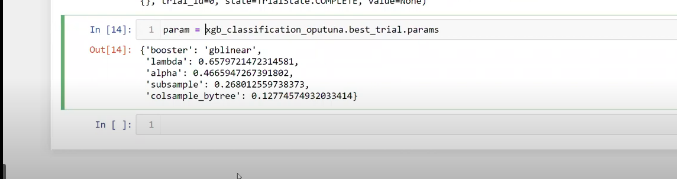